# Multi-controlled gate decomposition

In this notebook we will implement an algorithm from [this paper](https://arxiv.org/pdf/quant-ph/9503016.pdf) decomposing multi-controlled gate into sequence of 1-qubit gates, CNOT and Toffoli gates.


In [29]:
import numpy as np
import cirq
from scipy.stats import unitary_group
from matplotlib import pyplot as plt

In [110]:
def unitary_power(U, p):
    """Raises unitary matrix U to power p."""
    assert cirq.is_unitary(U)
    eig_vals, eig_vectors = np.linalg.eig(U)
    Q = np.array(eig_vectors)
    return Q @ np.diag(np.exp(p * 1j * np.angle(eig_vals))) @ Q.conj().T

def is_identity(M):
    return np.allclose(M, np.eye(M.shape[0]))

_Ry = lambda x: np.array([[np.cos(x/2), np.sin(x/2)], [-np.sin(x/2), np.cos(x/2)]])
_Rz = lambda x: np.diag(np.exp([0.5j * x, -0.5j * x]))
_flatten = lambda x: sum(x, [])

def ccnot_explicit(c0, c1, target):
    """Implements action of Toffoli gate with controls `c1` and `c2` on `target`."""
    return [
        cirq.H.on(target),
        cirq.CNOT.on(c1, target),
        cirq.ZPowGate(exponent=-0.25).on(target),
        cirq.CNOT.on(c0, target),
        cirq.T.on(target),
        cirq.CNOT.on(c1, target),
        cirq.ZPowGate(exponent=-0.25).on(target),
        cirq.CNOT.on(c0, target),
        cirq.T.on(c1),
        cirq.T.on(target),
        cirq.H.on(target),
        cirq.CNOT.on(c0, c1),
        cirq.T.on(c0),
        cirq.ZPowGate(exponent=-0.25).on(c1),
        cirq.CNOT.on(c0, c1),
    ]


def ccnot_congruent(c0, c1, target):
    """Almost CCNOT, but multiplies 4th qubit by -1. See lemma 6.2."""
    return [
        cirq.ry(-np.pi/4).on(target),
        cirq.CNOT(c1, target),
        cirq.ry(-np.pi/4).on(target),
        cirq.CNOT(c0, target),
        cirq.ry(np.pi/4).on(target),
        cirq.CNOT(c1, target),
        cirq.ry(np.pi/4).on(target),
    ]
 

def multi_ctrl_x(controls, target, free_qubits=[]):
    """Implements action of multi-controlled Pauli X gate .
    
    Result is guaranteed to consist exclusively of 1-qubit and CNOT gates. 
    
    If `free_qubits` has at least 1 element, result has length O(len(controls)). 
    
    Args:
        controls - control qubits.
        targets - target qubits.
        free_qubits - qubits which are neither controlled nor target, but on which 
            we are allowed to act. They can be in any state and algorithm is guaranteed
            to return them in the same state.
    """
    m = len(controls)
    if m == 0:
        return [cirq.X.on(target)]
    elif m == 1:
        return [cirq.CNOT.on(controls[0], target)]
    elif m == 2:
        return ccnot_explicit(controls[0], controls[1], target)
            
    m = len(controls)
    n = m + 1 + len(free_qubits) 
    if (n >= 2 * m - 1) and (m >=3):
        # Lemma 7.2.
        seq1 = [ccnot_congruent(controls[m-2-i], free_qubits[m-4-i], free_qubits[m-3-i]) for i in range(m-3)]
        seq2 = _flatten(seq1) + ccnot_congruent(controls[0], controls[1], free_qubits[0]) + _flatten(seq1[::-1]) 
        first_gate = ccnot_explicit(controls[m-1], free_qubits[m-3], target)
        return first_gate + seq2 + first_gate + seq2 
    elif len(free_qubits) >= 1: 
        # Lemma 7.3. 
        m1 = n // 2
        seq1 = multi_ctrl_x(controls[:m1], free_qubits[0], free_qubits=controls[m1:] + [target] + free_qubits[1:])
        seq2 = multi_ctrl_x(controls[m1:] + [free_qubits[0]], target, free_qubits = controls[:m1] + free_qubits[1:])
        return seq1 + seq2 + seq1 + seq2
    else: 
        # No free qubit - must use main algorithm.
        # This will never happen if called from main algorithm and is added only for completeness.
        X = np.array([[0, 1], [1,0]])
        return decompose_fc_gate(X, controls, target)
    
def decompose_fc_gate(U, controls, target, free_qubits=[], power=1.0):
    """Implements action of multi-controlled unitary gate U^power.
    
    Result is guaranteed to consist exclusively of 1-qubit and CNOT gates.
    
    If `free_qubits` has at least 1 element, result has length O(len(controls)). 
    
    Args:
        U - 2x2 numpy unitary matrix (of real or complext type).
        controls - control qubits. Must be non-empty.
        targets - target qubits.
        free_qubits - qubits which are neither controlled nor target, but on which 
            we are allowed to act. They can be in any state and algorithm is guaranteed
            to return them in the same state.
        power - power in which U should be raised.
    """
    assert cirq.is_unitary(U)
    assert U.shape == (2, 2)

    M = unitary_power(U, power)

    # Matrix parameters, see definitions in chapter 4.
    delta = np.angle(np.linalg.det(M)) * 0.5    
    alpha = np.angle(M[0,0]) + np.angle(M[0,1]) - 2 * delta
    beta = np.angle(M[0,0]) - np.angle(M[0,1])
    theta = 2 * np.arccos(np.abs(M[0,0]))
    
    # Decomposing matrix as per Lemma 4.3.
    A = _Rz(alpha) @ _Ry(theta/2)
    B = _Ry(-theta/2) @ _Rz(-(alpha+beta)/2)
    C = _Rz((beta-alpha)/2)
    X = np.array([[0, 1], [1, 0]])
    assert np.allclose(A @ B @ C, np.eye(2))
    assert np.allclose(A @ X @ B @ X @ C, M / np.exp(1j * delta), atol=1e-3)

    m = len(controls) 
    
    if m == 1:
        # Chapter 5.1.
        result = [
            cirq.ZPowGate(exponent=delta/np.pi).on(controls[0]),
            cirq.rz(-0.5*(beta-alpha)).on(target),
            cirq.CNOT.on(controls[0], target),
            cirq.rz(0.5*(beta+alpha)).on(target),
            cirq.ry(0.5*theta).on(target),
            cirq.CNOT.on(controls[0], target),
            cirq.ry(-0.5*theta).on(target),
            cirq.rz(-alpha).on(target),
        ]
        
        # Remove no-ops.
        result = [g for g in result if not is_identity(g._unitary_())]
        
        return result
    else:   
        gate_is_special_unitary = np.allclose(delta, 0)
        
        if gate_is_special_unitary:
            # O(n) decomposition - Lemma 7.9.
            cnot_seq = multi_ctrl_x(controls[:-1], target, free_qubits=[controls[-1]])
            result = []
            result += decompose_fc_gate(C, [controls[-1]], target)
            result += cnot_seq
            result += decompose_fc_gate(B, [controls[-1]], target)
            result += cnot_seq
            result += decompose_fc_gate(A, [controls[-1]], target) 
            return result   
        else:
            # O(n^2) decomposition - Lemma 7.5.
            cnot_seq = multi_ctrl_x(controls[:-1], controls[-1], free_qubits=free_qubits+[target])
            part1 = decompose_fc_gate(U, [controls[-1]], target, power=0.5*power) 
            part2 = decompose_fc_gate(U, [controls[-1]], target, power=-0.5*power) 
            part3 = decompose_fc_gate(U, controls[:-1], target, free_qubits=free_qubits+[controls[-1]], power=0.5*power)
            return part1 + cnot_seq + part2 + cnot_seq + part3            
    
    return circuit

In [111]:
# Test correctness of multi-controlled X decomposition.

for n in range(2, 8):
    qubits = cirq.LineQubit.range(n)
    for m in range(0, n):
        gates = multi_ctrl_x(qubits[:m], qubits[m], free_qubits=qubits[m+1:])

        c1 = cirq.Circuit([cirq.I.on(q) for q in qubits])
        c1.append(gates)
        result_matrix = c1.unitary()

        c2 = cirq.Circuit([cirq.I.on(q) for q in qubits])
        c2 += cirq.ControlledGate(cirq.X, num_controls = m).on(*qubits[0:m+1])
        expected_matrix = c2.unitary()
        assert np.allclose(expected_matrix, result_matrix)
        
print("OK")            

OK


In [112]:
# Test correctness of multi-controlled unitary decomposition.

np.random.seed(88)

cnot_matrix = cirq.CNOT._unitary_()

def random_special_unitary():
    U = unitary_group.rvs(2)
    return U / np.sqrt(np.linalg.det(U))

def test_decomposition(U, m):
    qubits = cirq.LineQubit.range(m+1)

    gates = decompose_fc_gate(U, qubits[:-1], qubits[-1])

    # Verify that all gates are either CNOT 1-qubit gates.
    for gate in gates:
        u = gate._unitary_()
        assert u.shape == (2, 2) or (u.shape == (4,4) and np.allclose(u, cnot_matrix))

    result_matrix = cirq.Circuit(gates).unitary()
    d = 2**(m+1)
    expected_matrix = np.eye(d, dtype=np.complex128)
    expected_matrix[d-2:d, d-2:d] = U

    assert np.allclose(expected_matrix, result_matrix)
    

for gate in [cirq.X, cirq.Y, cirq.Z, cirq.H, cirq.I, cirq.T]:
    for m in range(1, 7):
        test_decomposition(gate._unitary_(), m)
print ("Specific matrices - OK")

for _ in range(5):
    U = unitary_group.rvs(2)
    for m in range(1, 7):
        test_decomposition(U, m)
print ("Unitary matrices - OK")
    
for _ in range(5):
    U = random_special_unitary()
    for m in range(1, 7):
        test_decomposition(U, m)
print ("Special unitary matrices - OK")

U = random_special_unitary()
for m in range(7, 9):
    test_decomposition(U, m)
    print ("Special unitary, m=%d - OK" % m)

Specific matrices - OK
Unitary matrices - OK
Special unitary matrices - OK
Special unitary, m=7 - OK
Special unitary, m=8 - OK


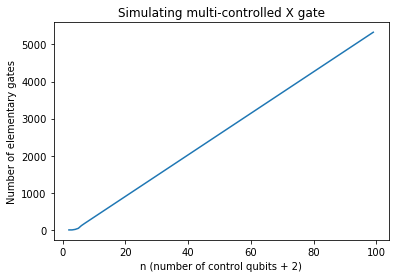

Exact line is -216.00 + 56.00 * x.


In [113]:
# Check linearity of simulating ∧_(n−2)(X) - as per chapter 7.1. 

def fit_exact_line(x, y, pos=10):
    a = (y[pos+1]-y[pos])/(x[pos+1]-x[pos])
    b = y[pos] - a * x[pos]
    for i in range(pos, len(x)):
        assert y[i] == a*x[i] + b
    print("Exact line is %.02f + %.02f * x." % (b, a))

n_range = list(range(2, 100))
gates_count = []
for n in n_range:
    qubits = cirq.LineQubit.range(n)
    gates = multi_ctrl_x(qubits[:-2], qubits[-1], free_qubits=[qubits[-2]])
    gates_count.append(len(gates))
    
plt.plot(n_range, gates_count)
plt.xlabel('n (number of control qubits + 2)')
plt.ylabel('Number of elementary gates')
plt.title('Simulating multi-controlled X gate')
plt.show()
fit_exact_line(n_range, gates_count)

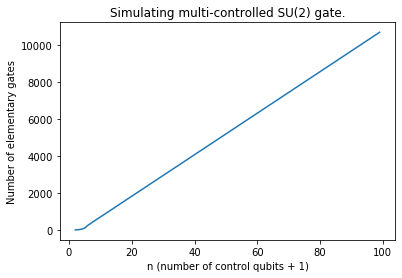

Exact line is -414.00 + 112.00 * x.


In [114]:
# Check linearity of simulating multi-controlled SU gate. 

U = random_special_unitary()
n_range = list(range(2, 100))
gates_count = []
for n in n_range:
    qubits = cirq.LineQubit.range(n)
    gates = decompose_fc_gate(U, qubits[:-1], qubits[-1])
    gates_count.append(len(gates))
    
plt.plot(n_range, gates_count)
plt.xlabel('n (number of control qubits + 1)')
plt.ylabel('Number of elementary gates')
plt.title('Simulating multi-controlled SU(2) gate.')
plt.show()
fit_exact_line(n_range, gates_count)

In [ ]:
# Complexity of simulating multi-controlled general unitary gate. 

U = unitary_group.rvs(2)
n_range = list(range(2, 100))
gates_count = []
for n in n_range:
    qubits = cirq.LineQubit.range(n)
    gates = decompose_fc_gate(U, qubits[:-1], qubits[-1])
    gates_count.append(len(gates))
    
plt.plot(n_range, gates_count)
plt.xlabel('n (number of control qubits + 1)')
plt.ylabel('Number of elementary gates')
plt.title('Simulating multi-controlled U(2) gate.')
plt.show()

Why is it becoming linear at n >= 60? Because matrix square gets called so much times, the matrix becomes very close to identity, which is detected as special unitary, and corresponding linear algorithm is appllied.